In [1]:
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import glob
import matplotlib.pyplot as plt
import shutil
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda")
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from IPython.core.debugger import set_trace

True 4


In [2]:
data_dir = '/data/kanferg/Images/Pex_project/SIngle_cell_images_training_set/01242024/pytorch_test/seg_train/'
test_data_dir = '/data/kanferg/Images/Pex_project/SIngle_cell_images_training_set/01242024/pytorch_test/seg_test/'

dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((60,60)),transforms.ColorJitter(),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((60,60)),transforms.ColorJitter(),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))

img, label = dataset[0]

print(img.shape,label) 
print("Follwing classes are there : \n",dataset.classes)

torch.Size([3, 60, 60]) 0
Follwing classes are there : 
 ['PEX', 'WT']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : PEX


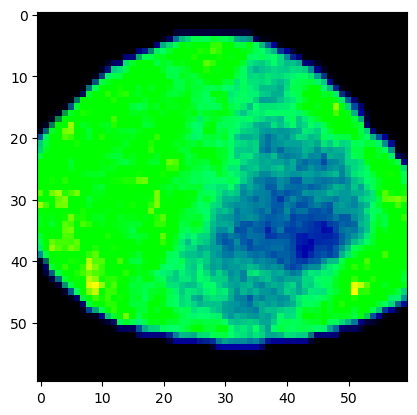

In [3]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))
'''
In the function `img.permute(1,2,0)`, `permute(1,2,0)` is used to change the dimensions of the `img` object.

The `img` object has dimensions `torch.Size([3, 150, 150])`, which means it has 3 channels (RGB) and an image size of 150x150 pixels.
'''
#display the first image in the dataset
display_img(*dataset[1])

In [4]:
img[2,:,:]

tensor([[ 0.2348, -0.1487,  0.0953,  ..., -0.3404, -0.3404, -0.3404],
        [ 0.2173,  0.0082,  0.1302,  ..., -0.3404, -0.3404, -0.3404],
        [ 0.1476, -0.0790,  0.1651,  ..., -0.3404, -0.3404, -0.3404],
        ...,
        [-0.3404, -0.3404, -0.3404,  ...,  0.3568,  0.4788,  0.5136],
        [-0.3404, -0.3404, -0.3404,  ...,  0.4962,  0.4962,  0.5834],
        [-0.3404, -0.3404, -0.3404,  ...,  0.4788,  0.5311,  0.5485]])

In [5]:
batch_size = 4
val_size = 1000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 15000*0.8
#Length of Validation Data : 15000*0.2

#load the train and validation into batches.
# train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)
train_dl = DataLoader(train_data, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, pin_memory = True)

Length of Train Data : 14000
Length of Validation Data : 1000


In [6]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        criterion = nn.BCEWithLogitsLoss()
        out = self(images)                  # Generate predictions
        loss = criterion(out, labels.float()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        criterion = nn.BCEWithLogitsLoss()
        labels = labels.view(-1, 1)
        loss = criterion(out, labels.float())  # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16,64, kernel_size = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128 ,128, kernel_size = 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(1*1*128, 512), #incase of 60 by 60 input image
            #nn.Linear(7*7*128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, xb):
        return self.network(xb)

In [8]:
def accuracy(outputs, labels):
    preds = outputs > 0.5
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for i,batch in enumerate(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # if i % 10 == 0:
            #     result = evaluate(model, val_loader)
            #     result['train_loss'] = torch.stack(train_losses).mean().item()
            #     model.epoch_end(epoch, result)
        
        print(epoch)
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [9]:
model = NaturalSceneClassification().to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


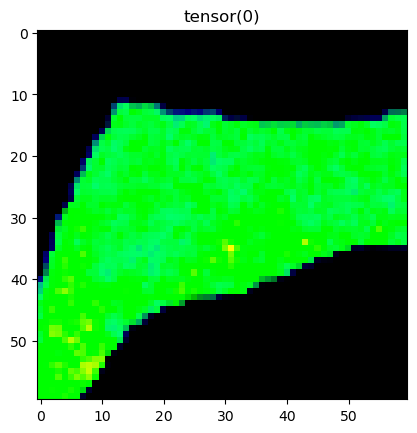

In [10]:
for i, data in enumerate(train_dl, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    if i  == 0:
        break
imgTest = inputs[0,:,:,:]
plt.imshow(imgTest.permute(1,2,0))
plt.title(labels[0])
plt.show()
inputs,labels = inputs.to(device),labels.to(device)

In [11]:
labels.shape

torch.Size([4])

In [12]:
# input_tensor = torch.randn(30, 3, 50, 50)
# optimizer= torch.optim.SGD(model.parameters(), lr=0.001)


In [13]:
# model(inputs)
# criterion = nn.BCEWithLogitsLoss()
# labels = labels.view(-1, 1)
# loss = criterion(model(inputs), labels.float())
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

In [14]:
import torch
print(torch.__version__)

2.1.0.post303


In [15]:
num_epochs = 30
# opt_func = torch.optim.Adam
opt_func= torch.optim.SGD
lr = 0.05
# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
#torch.save(model.state_dict(), "model_test.pth")

/gpfs/gsfs10/users/kanferg/conda/envs/cellpose_utsw/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1705951072540/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [0], train_loss: 0.6019, val_loss: 0.7158, val_acc: 0.4840
Epoch [0], train_loss: 0.7236, val_loss: 0.7147, val_acc: 0.4840
Epoch [0], train_loss: 0.7173, val_loss: 0.7140, val_acc: 0.4840
Epoch [0], train_loss: 0.7187, val_loss: 0.7131, val_acc: 0.4840
Epoch [0], train_loss: 0.7162, val_loss: 0.7124, val_acc: 0.4840
Epoch [0], train_loss: 0.7146, val_loss: 0.7116, val_acc: 0.4840
Epoch [0], train_loss: 0.7210, val_loss: 0.7102, val_acc: 0.4840
Epoch [0], train_loss: 0.7220, val_loss: 0.7091, val_acc: 0.4840
Epoch [0], train_loss: 0.7200, val_loss: 0.7082, val_acc: 0.4840
Epoch [0], train_loss: 0.7146, val_loss: 0.7078, val_acc: 0.4840
Epoch [0], train_loss: 0.7135, val_loss: 0.7067, val_acc: 0.4840


KeyboardInterrupt: 

tensor([[1],
        [0],
        [0],
        [0]], device='cuda:0')

tensor([[0.5050],
        [0.5042],
        [0.5044],
        [0.5046]], device='cuda:0')

In [39]:
out = torch.tensor([[0.5050],[0.5042],[0.5044],[0.5046]])
label = torch.tensor([[1],[0],[0],[0]])

_, preds = torch.max(out, dim=0)
torch.tensor(torch.sum(preds == label).item() / len(preds))

tensor(3.)

In [43]:
out = torch.tensor([[0.5050],[0.5042],[0.5044],[0.5046]])
label = torch.tensor([[1],[0],[0],[0]])

preds = out > 0.5
torch.tensor(torch.sum(preds == label).item() / len(preds))

tensor(0.2500)

In [42]:
model(torch.randn(30, 3, 50, 50).to(device))

tensor([[0.5049],
        [0.5048],
        [0.5051],
        [0.5055],
        [0.5049],
        [0.5048],
        [0.5045],
        [0.5049],
        [0.5054],
        [0.5051],
        [0.5043],
        [0.5052],
        [0.5054],
        [0.5052],
        [0.5050],
        [0.5050],
        [0.5048],
        [0.5051],
        [0.5052],
        [0.5046],
        [0.5052],
        [0.5047],
        [0.5050],
        [0.5043],
        [0.5046],
        [0.5053],
        [0.5049],
        [0.5044],
        [0.5046],
        [0.5050]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [24]:
# change fit function acording to https://www.kaggle.com/code/abhishekrathi09/pytorch-basics-part-4-optimize-model-parameters
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        size = len(train_loader.dataset)
        for i, batch in enumerate(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                images, labels = batch
                loss, current = loss.item(), i * len(images)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # result = evaluate(model, val_loader)
        # result['train_loss'] = torch.stack(train_losses).mean().item()
        # model.epoch_end(epoch, result)
        # history.append(result)
    
    return history

num_epochs = 30
# opt_func = torch.optim.Adam
opt_func= torch.optim.SGD
lr = 0.001
# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
#torch.save(model.state_dict(), "model_test.pth")

loss: 0.662051  [    0/14000]
loss: 0.782744  [ 1600/14000]
loss: 0.691786  [ 3200/14000]
loss: 0.751883  [ 4800/14000]
loss: 0.691496  [ 6400/14000]
loss: 0.661097  [ 8000/14000]
loss: 0.751212  [ 9600/14000]
loss: 0.779935  [11200/14000]
loss: 0.720527  [12800/14000]
loss: 0.631215  [    0/14000]
loss: 0.690133  [ 1600/14000]
loss: 0.660823  [ 3200/14000]
loss: 0.660905  [ 4800/14000]
loss: 0.777120  [ 6400/14000]
loss: 0.660817  [ 8000/14000]
loss: 0.689434  [ 9600/14000]
loss: 0.631910  [11200/14000]
loss: 0.660414  [12800/14000]
loss: 0.659996  [    0/14000]
loss: 0.746385  [ 1600/14000]
loss: 0.717768  [ 3200/14000]
loss: 0.660177  [ 4800/14000]
loss: 0.744499  [ 6400/14000]
loss: 0.659508  [ 8000/14000]
loss: 0.714186  [ 9600/14000]
loss: 0.770315  [11200/14000]
loss: 0.714481  [12800/14000]
loss: 0.658938  [    0/14000]
loss: 0.713179  [ 1600/14000]
loss: 0.631369  [ 3200/14000]
loss: 0.819395  [ 4800/14000]
loss: 0.738375  [ 6400/14000]
loss: 0.605376  [ 8000/14000]
loss: 0.70

KeyboardInterrupt: 